In [1]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
%cd /content/drive/MyDrive/MSc Computational Neuroscience, Cognition & AI/MLis2/ML Project/code/YOLOv3_TF2/


from yolov3_tf2.utils import draw_outputs
from yolov3_tf2.yolo import YoloV3
from yolov3_tf2.yolo_tiny import YoloV3Tiny


Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1lVSXhv7tm507dxrIt3znhnHFrg6oJRq8/ML Project/code/YOLOv3_TF2


In [124]:
class Road:

  def __init__(self, check=False):    
    self.check=check
    self.width, self.height, self.channels = 320, 240, 3
    # object detection YOLO
    self.yolo = YoloV3(classes=8, yolo_max_boxes=5, yolo_iou_threshold=0.2, yolo_score_threshold=0.6) #0.03
    self.yolo.load_weights('./weights/yolo.tf').expect_partial()
    #self.yolo = YoloV3Tiny(classes=8, yolo_max_boxes=5, yolo_iou_threshold=0.03, yolo_score_threshold=0.03) #0.03
    #self.yolo.load_weights('./weights/yolo_tiny.tf').expect_partial()
    # road segmentation UNET
    self.H_unet=128
    self.unet=keras.models.load_model('./weights/unet.h5', custom_objects={'dice_coefficient':0})
    #angle prediction NVIDIA
    self.H_nvidia, self.W_nvidia=88, 128
    self.nvidia=keras.models.load_model('./weights/nvidia_0049.h5') #nvidia.h5
    self.left=keras.models.load_model('./weights/left_0049.h5') # left.h5
    self.right=keras.models.load_model('./weights/right_0049.h5') #right.h5
    # init detection parameters
    self.min_box_area=np.array([1500 ,8000, 800, 1800 ,600 , 800, 1800, 800])
    self.class_names=['box','car', 'green light', 'left signal', 'person', 'red light', 'right signal', 'tree']

  def Is_close(self, name, box):
    xmin, ymin, xmax, ymax=box
    area=(xmax-xmin)*(ymax-ymin)*(self.height*self.width)/self.H_unet**2
    class_id=self.class_names.index(name)
    threshold=self.min_box_area[class_id]
    return (area>threshold)

  def Is_obstacle(self,obstacles, road):
    obj=np.zeros_like(road)
    road_bbox=np.copy(road)*0.5
    for box in obstacles:
      xmin, ymin, xmax, ymax=box
      road[ymin:ymax, xmin:xmax]+=0.3*np.ones_like(road[ymin:ymax, xmin:xmax])
      yc=ymin+(ymax-ymin)//2
      if (ymax-ymin)<(xmax-xmin):
        yc=ymin
      obj[yc:ymax, xmin:xmax]=1
      union=np.sum(np.multiply(road, obj))/((ymax-yc)*(xmax-xmin))    
      if union>0.20:
        if self.check:
          print('union=', union, 'box=', xmin,  xmax, ymin, ymax)
          fig, axs=plt.subplots(nrows=1, ncols=2)
          axs[1].imshow(road); axs[0].imshow(road_bbox)  
        return True
    return False

  def Angle(self, img, Left, Right):
    img = cv2.resize(img, ( self.H_unet,self.H_unet))
    img=np.reshape(img, (1, self.H_unet, self.H_unet,3))
    lanes=self.unet.predict(img)
    lanes=np.reshape(lanes, (self. H_unet, self.H_unet))
    crop=self.H_unet-self.H_nvidia
    mask =lanes[crop: , :self.W_nvidia]
    mask =np.reshape(mask , (1, self.H_nvidia, self.W_nvidia, 1) )
    if Left or Right:
      if Left:
        angle=self.left.predict(mask)
      if Right:
        angle=self.right.predict(mask)
    else:
      angle=self.nvidia.predict(mask)
    angle=min(float(angle), 1)
    angle=max(float(angle), 0)
    return angle, lanes

  def Is_end_road(self, lanes, angle):
    mask=lanes[:-10, :]>0.6
    THR=7
    if angle<0.35:
      S=np.sum(mask[:,:7])
      horizon=np.sum(mask[:55,:])
    if angle>0.65 :
      S=np.sum(mask[:,-7:])
      horizon=np.sum(mask[:55,:])
    if (angle<0.65)*(angle>0.35):
      horizon=np.sum(mask[:60,:])
      S=np.sum(mask[:,self.H_unet//2-4:self.H_unet//2+4])
    end=(S<THR)*(horizon<1)
    if self.check:
      print( 'End_road:',end, 'S=',S,'horizon=' , horizon)
    return end
    
  def Object(self,img_raw):
    img_ = tf.expand_dims(img_raw, 0)
    img_ = tf.image.resize(img_, (416, 416))
    img_ = img_/ 255
    boxes, scores, classes, nums = self.yolo(img_)     
    new_boxes, new_classes, new_scores=[],[],[]
    for i in range(nums[0]):
      name=self.class_names[int(classes[0][i])]
      new_classes.append(name)
      new_scores.append(np.array(scores[0][i]))
      new_boxes.append(np.array(boxes[0][i]))
    converted_boxes=[]
    for box in new_boxes:
      x1, y1, x2, y2=box 
      xmin=abs(int(x1*self.H_unet))
      xmax=abs(int(x2*self.H_unet))
      ymin=abs(int(y1*self.H_unet))
      ymax=abs(int(y2*self.H_unet))
      xmin, ymax=max(1, xmin), min(self.H_unet-1 , ymax)
      converted_boxes.append([xmin,ymin, xmax, ymax])
    if self.check:
      #to remove
      image = cv2.cvtColor(img_raw, cv2.COLOR_RGB2BGR)
      image= draw_outputs(image, (boxes, scores, classes, nums), self.class_names)
      plt.imsave('/content/object_detection.png', image)
      from IPython.display import Image, display
      display(Image(data=bytes(cv2.imencode('.jpg', image)[1]), width=300))
      print('score=', new_scores, 'classes=', new_classes, 'boxes=', converted_boxes)
    return converted_boxes,new_classes, new_scores
 

  def Mask(self, mask, angle, THR=0.7):
    step=3
    end_road=False
    M,N=mask.shape[0], mask.shape[1]
    new_mask=np.zeros((M,N))
    x_start=(N//2)*(angle>0.35)*(angle<0.65)+(N//2-30)*(angle<0.35)+(N//2+30)*(angle>0.65)
    prev_x1, prev_x2= 0, N
    first_lane=False
    for y in np.flip(np.arange(step, M-10, step)):
      x1=0; x2=N
      # find left lane
      x=x_start
      while (x>1)*(x1==0):
        if mask[y,x]>THR:
          x1=x
        x-=1
      # find right lane
      x=x_start
      while (x<N-1)*(x2==N):
        if mask[y,x]>THR:
          x2=x
        x+=1
      #update mask
      if  (x1!=0) or (x2!=N):
        first_lane=True
        if (x1!=x2)*( abs(prev_x2-prev_x1)>0.8*abs(x2-x1) ):
          x_start=(x1+x2)//2
          prev_x1, prev_x2=x1,x2
          new_mask[y:y+step, x1:x2]=1
      # if no lanes met: all ones if never met; else end
      else:
        if (y>M//3)*(first_lane==False):
          new_mask[y-step:y, x1:x2]=1
        if (y<M//3):
          break #return new_mask
    if (abs(prev_x2-prev_x1)>40)*(abs(prev_x2-prev_x1)<N-1):
      end_road=True
    return new_mask #, end_road


  def Predict(self, image):
    img=image[:,:,:3]
    speed, Left, Right, obstacles= 1, False, False, []
    close, obstacle= False,  False
    boxes, classes, scores =self.Object(img)
    if len(boxes)!=0:
      for box, name in zip(boxes, classes):
        if self.Is_close(name, box):
          close=True
          if name=='red light':
            speed=0
          Left=(name=='left signal')
          Right=(name=='right signal')
          if name=='box' or name=='car' or name=='person' or name=='tree':
            obstacles.append(box)
    angle, lanes= self.Angle(img, Left, Right)
    road=self.Mask(lanes, angle) #, end_road
    if self.Is_obstacle(obstacles, road):
      speed=0
      obstacle=True
    if self.Is_end_road(lanes, angle):
      speed=0

    if self.check:
      print(' obstacle=', obstacle, ' is_close=', close) #, 'end_raod=', end_road)
      print('PREDICTION : speed=', speed, 'angle=', angle)
    return speed, angle

road=Road()

# Evaluate

In [3]:
code_dir='/content/drive/My Drive/MSc Computational Neuroscience, Cognition & AI/MLis2/ML Project/code'

# test images
dataset_dir= os.path.join(code_dir,'data/training_data')
images_dir=os.path.join(dataset_dir, 'training_data')
images_list = os.listdir(images_dir)
print(len(images_list), images_list[:20])
# target values
dataframe = pd.read_csv(code_dir+"/YOLOv3_TF2/data/training_norm.csv")
dataset = np.array(dataframe.values)
SPEED=np.array(dataset[:, 2], dtype=int)
ANGLE=np.array(dataset[:, 1 ], dtype=float)
print(SPEED[:4], ANGLE[:4])

13810 ['9144.png', '9192.png', '911.png', '9129.png', '9139.png', '9063.png', '9079.png', '9194.png', '9207.png', '9095.png', '9145.png', '906.png', '9149.png', '9146.png', '9141.png', '9108.png', '9185.png', '9061.png', '903.png', '9105.png']
[0 1 1 1] [0.4375 0.8125 0.4375 0.625 ]


In [125]:
road=Road(check=True)

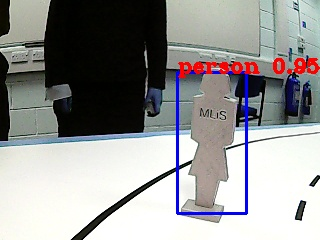

score= [array(0.9544395, dtype=float32)] classes= ['person'] boxes= [[70, 38, 98, 113]]
union= 1.0321428571428573 box= 70 98 38 113
End_road: False S= 86 horizon= 0
 obstacle= True  is_close= True
PREDICTION : speed= 0 angle= 0.6735635995864868
TARGET: speed= 0 angle= 0.5625
image 5828
inference time= 0.2695519020003303


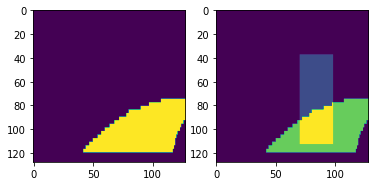

In [129]:
n=np.random.randint(1,len(images_list))

img_path=os.path.join(images_dir,str(n)+'.png')
img = cv2.imread(img_path)
t1=time.perf_counter()
speed, angle=road.Predict(img)
t2=time.perf_counter()
print('TARGET: speed=', SPEED[n-1], 'angle=', ANGLE[n-1])
print('image',n)
print('inference time=', t2-t1)